In [1]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

num_classes = 5
img_rows, img_cols = 32, 32
batch_size = 16


In [2]:
train_data_dir = 'C:/Users/prakash/Desktop/D-Split/train'
validation_data_dir = 'C:/Users/prakash/Desktop/D-Split/val'

# Let's use some data augmentaiton 
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      width_shift_range=0.3,
      height_shift_range=0.3,
      horizontal_flip=True,
      fill_mode='nearest')
 
validation_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_rows, img_cols),
        batch_size =batch_size,
        class_mode='categorical',
        shuffle=True)
 
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1440 images belonging to 5 classes.
Found 360 images belonging to 5 classes.


In [3]:
model = Sequential()

# Padding = 'same'  results in padding the input such that
# the output has the same length as the original input
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape= (img_rows, img_cols, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate RMSprop optimizer and configure some parameters
#opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [4]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


                     
checkpoint = ModelCheckpoint("C:/Users/prakash/Desktop/Project_Prakash/fruits_fresh_cnn_1.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint, reduce_lr]

# We use a very small learning rate 
model.compile(loss = 'categorical_crossentropy',
              optimizer = RMSprop(lr = 0.001),
              metrics = ['accuracy'])

nb_train_samples = 1440 
nb_validation_samples = 360
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)


Epoch 1/10
90/90 [==============================] - 11s 111ms/step - loss: 1.5148 - accuracy: 0.4126 - val_loss: 0.8082 - val_accuracy: 0.6818

Epoch 00001: val_loss improved from inf to 0.80819, saving model to C:/Users/prakash/Desktop/Project_Prakash\fruits_fresh_cnn_1.h5
Epoch 2/10
90/90 [==============================] - 11s 119ms/step - loss: 0.9471 - accuracy: 0.6205 - val_loss: 0.4472 - val_accuracy: 0.8636

Epoch 00002: val_loss improved from 0.80819 to 0.44718, saving model to C:/Users/prakash/Desktop/Project_Prakash\fruits_fresh_cnn_1.h5
Epoch 3/10
90/90 [==============================] - 11s 120ms/step - loss: 0.5587 - accuracy: 0.7978 - val_loss: 0.2657 - val_accuracy: 0.9261

Epoch 00003: val_loss improved from 0.44718 to 0.26570, saving model to C:/Users/prakash/Desktop/Project_Prakash\fruits_fresh_cnn_1.h5
Epoch 4/10
90/90 [==============================] - 11s 120ms/step - loss: 0.5590 - accuracy: 0.8573 - val_loss: 0.2452 - val_accuracy: 0.9290

Epoch 00004: val_loss i

In [5]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
class_labels = validation_generator.class_indices

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
#target_names = list(class_labels.values())
target_names =['Apple','Banana','Pineapple','Strawberry','Watermelon']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[158   1   1   0   0]
 [  0  60   0   0   0]
 [  0   0  60   0   0]
 [  0   0   0  60   0]
 [  0   0   0   0  20]]
Classification Report
              precision    recall  f1-score   support

       Apple       1.00      0.99      0.99       160
      Banana       0.98      1.00      0.99        60
   Pineapple       0.98      1.00      0.99        60
  Strawberry       1.00      1.00      1.00        60
  Watermelon       1.00      1.00      1.00        20

    accuracy                           0.99       360
   macro avg       0.99      1.00      1.00       360
weighted avg       0.99      0.99      0.99       360



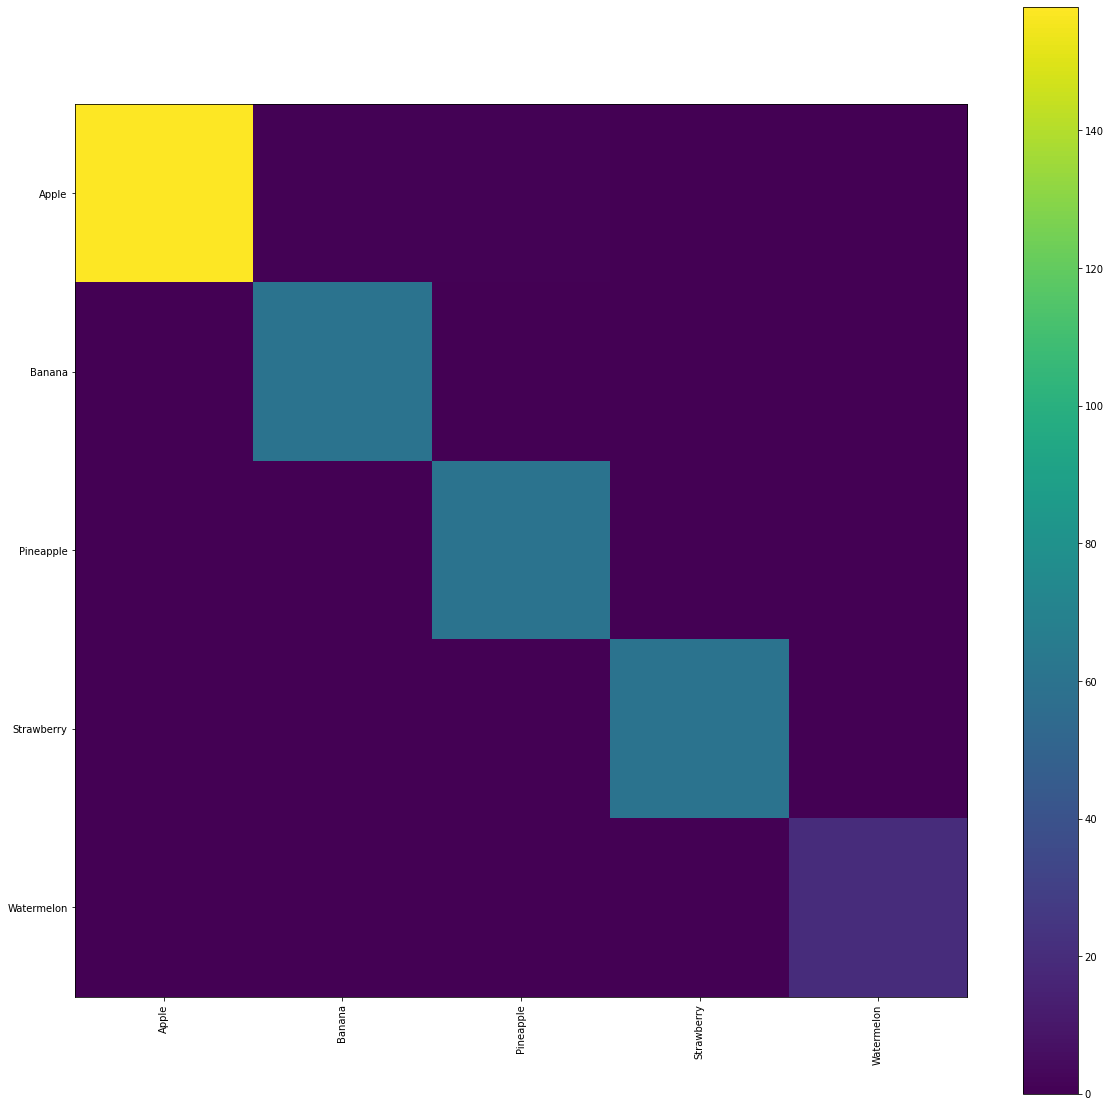

In [6]:

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model

img_row, img_height, img_depth = 32,32,3
model = load_model('C:/Users/prakash/Desktop/Project_Prakash/fruits_fresh_cnn_1.h5')

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())



#Confution Matrix and Classification Report
Y_pred = model.predict(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(20,20))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)

[[9.3690231e-02 2.5777406e-01 2.3461389e-03 6.4609128e-01 9.8318545e-05]]
The image is Strawberry


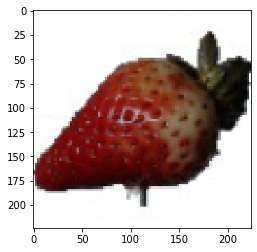

In [7]:
import os
import re
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

from keras.models import load_model
from keras.preprocessing import image

import cv2
from keras.models import load_model
from keras.preprocessing import image
path = 'C:/Users/prakash/Desktop/D/Check/1.jpg' 
predictions = []

#img, final_path, true_label = getRandomImage(path, img_width, img_height)
#files.append(final_path)
#true_labels.append(true_label)
x=image.load_img(path , target_size = (32,32))  
x = image.img_to_array(x)
x = x * 1./255
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

from tensorflow import keras
model = load_model('C:/Users/prakash/Desktop/Project_Prakash/fruits_fresh_cnn_1.h5')

classes = model.predict(images, batch_size = 10)
print(classes)
predictions.append(classes)

c=list(max(classes))
max_value = max(c)

img = image.load_img(path,target_size=(224,224))
img = np.asarray(img)
plt.imshow(img)

max_index = c.index(max_value)
#print(max_index)

if(max_index==0):
    print("The image is Apple")
elif(max_index==1):
    print("The image is Banana")
elif(max_index==2):
    print("The image is Pineapple")
elif(max_index==3):
    print("The image is Strawberry")
elif(max_index==4):
    print("The image is Watermelon")
    